In [1]:
import os
from opik import configure 
from dotenv import load_dotenv, find_dotenv
from opik.integrations.langchain import OpikTracer 
load_dotenv(find_dotenv())

True

In [2]:
configure()

OPIK: Opik is already configured. You can check the settings by viewing the config file at /Users/paddy/.opik.config
OPIK: Configuration completed successfully. Traces will be logged to 'FretCoach' project. To change the destination project, see: https://www.comet.com/docs/opik/tracing/log_traces#configuring-the-project-name


In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# from langchain.chat_models import init_chat_model
# model = init_chat_model("gpt-3.5-turbo")

from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# from langchain_anthropic import ChatAnthropic
# model = ChatAnthropic(model="MiniMax-M2.1", temperature=0, base_url=os.environ["ANTHROPIC_BASE_URL"])

# from langchain_deepseek import ChatDeepSeek
# model = ChatDeepSeek(
#     model="deepseek/deepseek-chat-v3.1",
#     api_key=os.getenv("OPENROUTER_API_KEY"),
#     api_base="https://openrouter.ai/api/v1",
#     max_tokens=4096,
#     extra_body={"reasoning": {"enabled": True}},
# )

In [4]:
from langchain_community.utilities import SQLDatabase

# Get PostgreSQL credentials from environment
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create PostgreSQL connection
db_uri = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
db = SQLDatabase.from_uri(db_uri)

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM future_jobs LIMIT 5;")}')

Dialect: postgresql
Available tables: ['future_jobs']
Sample output: [(1, 'Quantum Researcher', 'Quantum Computing', 'Singapore', 175780, 'Linear Algebra, Quantum Algorithms', 'No', 'Large', datetime.date(2025, 7, 22), 'Quantum Researcher Quantum Computing Linear Algebra, Quantum Algorithms Singapore'), (2, 'Renewable Energy Engineer', 'Green Tech', 'Singapore', 137481, 'Climate Data Analysis, Energy Modeling', 'Yes', 'Large', datetime.date(2025, 9, 26), 'Renewable Energy Engineer Green Tech Climate Data Analysis, Energy Modeling Singapore'), (3, 'Quantum Researcher', 'Quantum Computing', 'Tokyo', 182081, 'Linear Algebra, Qiskit', 'No', 'Medium', datetime.date(2025, 12, 31), 'Quantum Researcher Quantum Computing Linear Algebra, Qiskit Tokyo'), (4, 'Sustainability Analyst', 'Green Tech', 'Singapore', 113822, 'Climate Data Analysis, Energy Modeling', 'No', 'Large', datetime.date(2025, 5, 29), 'Sustainability Analyst Green Tech Climate Data Analysis, Energy Modeling Singapore'), (5, 'Smar

In [5]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [6]:
from typing import Literal

from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = model.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

IMPORTANT: In PostgreSQL, when using aggregate functions like MAX(), MIN(), COUNT(), etc.,
ALL non-aggregated columns in the SELECT clause MUST appear in the GROUP BY clause.
If you don't need grouping, use ORDER BY with LIMIT instead.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = model.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = model.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [7]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()
tracer = OpikTracer(graph=agent.get_graph(xray=True)) 

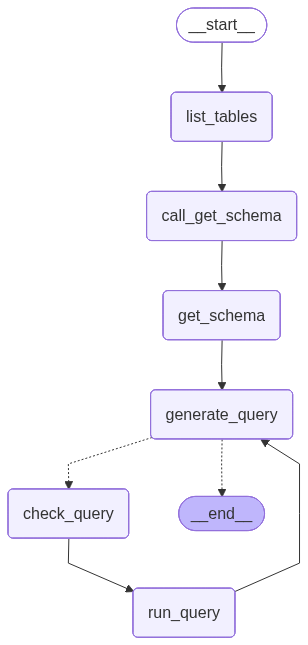

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [9]:
question = "Which job is the highest paid in 2025 in Tokyo?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
    config={"callbacks": [tracer]},  # Add this line to enable Opik tracing
):
    step["messages"][-1].pretty_print()

OPIK: Started logging traces to the "FretCoach" project at https://www.comet.com/opik/api/v1/session/redirect/projects/?trace_id=019bc247-704f-7122-9128-c902d580bd1c&path=aHR0cHM6Ly93d3cuY29tZXQuY29tL29waWsvYXBpLw==.


================================ Human Message =================================

Which job is the highest paid in 2025 in Tokyo?
================================== Ai Message ==================================

Available tables: future_jobs
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (a2404f4b-3fa2-4507-9364-dea083dbc70b)
 Call ID: a2404f4b-3fa2-4507-9364-dea083dbc70b
  Args:
    table_names: future_jobs
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE future_jobs (
	job_id BIGINT NOT NULL, 
	job_title TEXT, 
	industry TEXT, 
	location TEXT, 
	salary_usd BIGINT, 
	skills_required TEXT, 
	remote_option VARCHAR(20), 
	company_size VARCHAR(20), 
	posting_date DATE, 
	search_text TEXT GENERATED ALWAYS AS (((((((job_title || ' '::text) || industry) || ' '::text) || skills_required) || ' '::text) || location)) STORED, 
	CONSTRAINT future_jobs_pkey PRIMARY KEY (